# Telemetry Data Exploration - Race Replay

This notebook loads and analyzes high-frequency telemetry data from the Toyota GR Cup races.

**Features:**
- Load telemetry data (11.5M+ rows)
- Visualize car positions on track
- Replay race progression with position and interval times
- Track position changes throughout the race

In [1]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Telemetry Data

The telemetry data contains high-frequency sensor readings (~20Hz) including:
- GPS coordinates (VBOX_Long_Minutes, VBOX_Lat_Min)
- Lap distance (Laptrigger_lapdist_dls)
- Speed, acceleration, brake pressure
- Timestamps for each reading

In [2]:
# Configuration
DATA_FILE = Path('../dataset/data_files/barber/R1_barber_telemetry_data.csv')

print(f"Loading telemetry data from: {DATA_FILE}")
print("This may take 30-60 seconds due to file size (11.5M rows)...\n")

# Load the data
df = pd.read_csv(DATA_FILE)

print(f"✓ Data loaded successfully")
print(f"  Total rows: {len(df):,}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nColumns: {', '.join(df.columns)}")

Loading telemetry data from: ../dataset/data_files/barber/R1_barber_telemetry_data.csv
This may take 30-60 seconds due to file size (11.5M rows)...

✓ Data loaded successfully
  Total rows: 11,556,519
  Memory usage: 5962.2 MB

Columns: expire_at, lap, meta_event, meta_session, meta_source, meta_time, original_vehicle_id, outing, telemetry_name, telemetry_value, timestamp, vehicle_id, vehicle_number


In [3]:
# Display basic info
print("\n=== Data Overview ===")
print(df.head(20))
print("\n=== Data Types ===")
print(df.dtypes)
print("\n=== Summary Statistics ===")
print(df.describe())


=== Data Overview ===
    expire_at  lap        meta_event meta_session   meta_source  \
0         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
1         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
2         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
3         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
4         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
5         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
6         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
7         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
8         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
9         NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
10        NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
11        NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
12        NaN    2  I_R06_2025-09-07           R1  kafka:gr-raw   
13        NaN    2  I_R06_2025-09-07   

## 2. Prepare Data for Race Replay

We need to:
1. Pivot the data to get one row per timestamp with all telemetry values as columns
2. Extract GPS coordinates and lap distance for position tracking
3. Calculate running positions and intervals

In [4]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Get unique cars
unique_cars = sorted(df['vehicle_number'].unique())
print(f"Cars in race: {len(unique_cars)}")
print(f"Car numbers: {unique_cars}")

# Get unique telemetry types
telemetry_types = df['telemetry_name'].unique()
print(f"\nTelemetry types: {len(telemetry_types)}")
print(f"Available metrics: {', '.join(sorted(telemetry_types))}")

Cars in race: 20
Car numbers: [np.int64(0), np.int64(2), np.int64(3), np.int64(5), np.int64(7), np.int64(13), np.int64(16), np.int64(18), np.int64(21), np.int64(31), np.int64(46), np.int64(47), np.int64(55), np.int64(72), np.int64(78), np.int64(80), np.int64(88), np.int64(93), np.int64(98), np.int64(113)]

Telemetry types: 12
Available metrics: Laptrigger_lapdist_dls, Steering_Angle, VBOX_Lat_Min, VBOX_Long_Minutes, accx_can, accy_can, aps, gear, nmot, pbrake_f, pbrake_r, speed


In [5]:
# Extract key telemetry data for race position tracking
# We'll focus on: GPS coordinates, lap distance, lap number, speed

print("Extracting position data for each car...")

# Filter for key telemetry types
position_metrics = ['Laptrigger_lapdist_dls', 'VBOX_Long_Minutes', 'VBOX_Lat_Min', 'speed']
position_data = df[df['telemetry_name'].isin(position_metrics)].copy()

print(f"Filtered to {len(position_data):,} rows with position data")

# Pivot to get one row per (vehicle, timestamp, lap)
position_pivot = position_data.pivot_table(
    index=['vehicle_number', 'lap', 'timestamp'],
    columns='telemetry_name',
    values='telemetry_value',
    aggfunc='first'
).reset_index()

print(f"\nPivoted data shape: {position_pivot.shape}")
print(f"Columns: {', '.join(position_pivot.columns)}")
print(f"\nSample data:")
print(position_pivot.head(10))

Extracting position data for each car...
Filtered to 2,889,132 rows with position data

Pivoted data shape: (1043278, 7)
Columns: vehicle_number, lap, timestamp, Laptrigger_lapdist_dls, VBOX_Lat_Min, VBOX_Long_Minutes, speed

Sample data:
telemetry_name  vehicle_number  lap                        timestamp  \
0                            0    2 2025-09-05 00:27:38.589000+00:00   
1                            0    2 2025-09-05 00:27:38.632000+00:00   
2                            0    2 2025-09-05 00:27:38.675000+00:00   
3                            0    2 2025-09-05 00:27:38.718000+00:00   
4                            0    2 2025-09-05 00:27:38.763000+00:00   
5                            0    2 2025-09-05 00:27:38.805000+00:00   
6                            0    2 2025-09-05 00:27:38.848000+00:00   
7                            0    2 2025-09-05 00:27:38.892000+00:00   
8                            0    2 2025-09-05 00:27:38.935000+00:00   
9                            0    2 2025-

In [6]:
# Clean and prepare position data
pos_df = position_pivot.copy()

# Rename columns for clarity
pos_df = pos_df.rename(columns={
    'Laptrigger_lapdist_dls': 'lap_distance',
    'VBOX_Long_Minutes': 'longitude',
    'VBOX_Lat_Min': 'latitude'
})

# Drop rows with missing position data
pos_df = pos_df.dropna(subset=['lap_distance', 'longitude', 'latitude'])

# Sort by timestamp
pos_df = pos_df.sort_values(['timestamp', 'lap_distance'], ascending=[True, False])

print(f"Clean position data: {len(pos_df):,} rows")
print(f"Time range: {pos_df['timestamp'].min()} to {pos_df['timestamp'].max()}")
print(f"Duration: {(pos_df['timestamp'].max() - pos_df['timestamp'].min()).total_seconds() / 60:.1f} minutes")

Clean position data: 216,003 rows
Time range: 2025-09-04 18:25:20.166000+00:00 to 2025-09-05 20:08:08.214000+00:00
Duration: 1542.8 minutes


## 3. Calculate Race Positions and Intervals

For each timestamp, we'll:
1. Rank cars by lap number and lap distance
2. Calculate time intervals between consecutive positions
3. Track position changes

In [7]:
# Function to calculate positions at each timestamp
def calculate_positions(df):
    """Calculate race position based on lap and distance."""
    # For each timestamp, rank by lap (descending) then lap_distance (descending)
    df['position'] = df.groupby('timestamp').apply(
        lambda x: x.assign(
            position=x.sort_values(['lap', 'lap_distance'], ascending=[False, False])
                     .reset_index(drop=True).index + 1
        )['position']
    ).droplevel(0).values
    
    return df

print("Calculating positions for each timestamp...")
print("This may take a minute...\n")

pos_df = calculate_positions(pos_df)

print("✓ Positions calculated")
print(f"\nSample with positions:")
print(pos_df[['timestamp', 'vehicle_number', 'lap', 'lap_distance', 'position']].head(20))

Calculating positions for each timestamp...
This may take a minute...

✓ Positions calculated

Sample with positions:
telemetry_name                        timestamp  vehicle_number  lap  \
831020         2025-09-04 18:25:20.166000+00:00              78    4   
831018         2025-09-04 18:25:20.166000+00:00              78    2   
831019         2025-09-04 18:25:20.166000+00:00              78    3   
831021         2025-09-04 18:25:20.166000+00:00              78    5   
831022         2025-09-04 18:25:20.166000+00:00              78    6   
831024         2025-09-04 18:25:20.166000+00:00              78    8   
831026         2025-09-04 18:25:20.166000+00:00              78   10   
831032         2025-09-04 18:25:20.166000+00:00              78   16   
831036         2025-09-04 18:25:20.166000+00:00              78   20   
831025         2025-09-04 18:25:20.166000+00:00              78    9   
831041         2025-09-04 18:25:20.166000+00:00              78   25   
831023         202

In [8]:
# Calculate intervals between cars
def calculate_intervals(df):
    """Calculate time interval to car ahead."""
    df = df.sort_values(['timestamp', 'position'])
    
    # For each timestamp, calculate time gap to previous position
    # Leader has no interval
    df['interval_seconds'] = df.groupby('timestamp')['timestamp'].diff()
    df['interval_seconds'] = df['interval_seconds'].dt.total_seconds()
    
    # For actual race intervals, we need cumulative distance/speed calculation
    # For now, mark leader as 0.0
    df.loc[df['position'] == 1, 'interval_seconds'] = 0.0
    
    return df

print("Calculating intervals...\n")
pos_df = calculate_intervals(pos_df)

print("✓ Intervals calculated")
print(f"\nSample with intervals:")
sample = pos_df[pos_df['timestamp'] == pos_df['timestamp'].iloc[1000]].sort_values('position')
print(sample[['position', 'vehicle_number', 'lap', 'lap_distance', 'interval_seconds']])

Calculating intervals...

✓ Intervals calculated

Sample with intervals:
telemetry_name  position  vehicle_number  lap  lap_distance  interval_seconds
534864                 1              31    1        3332.0               0.0


## 4. Visualize Track Layout

Plot the track using GPS coordinates from all cars

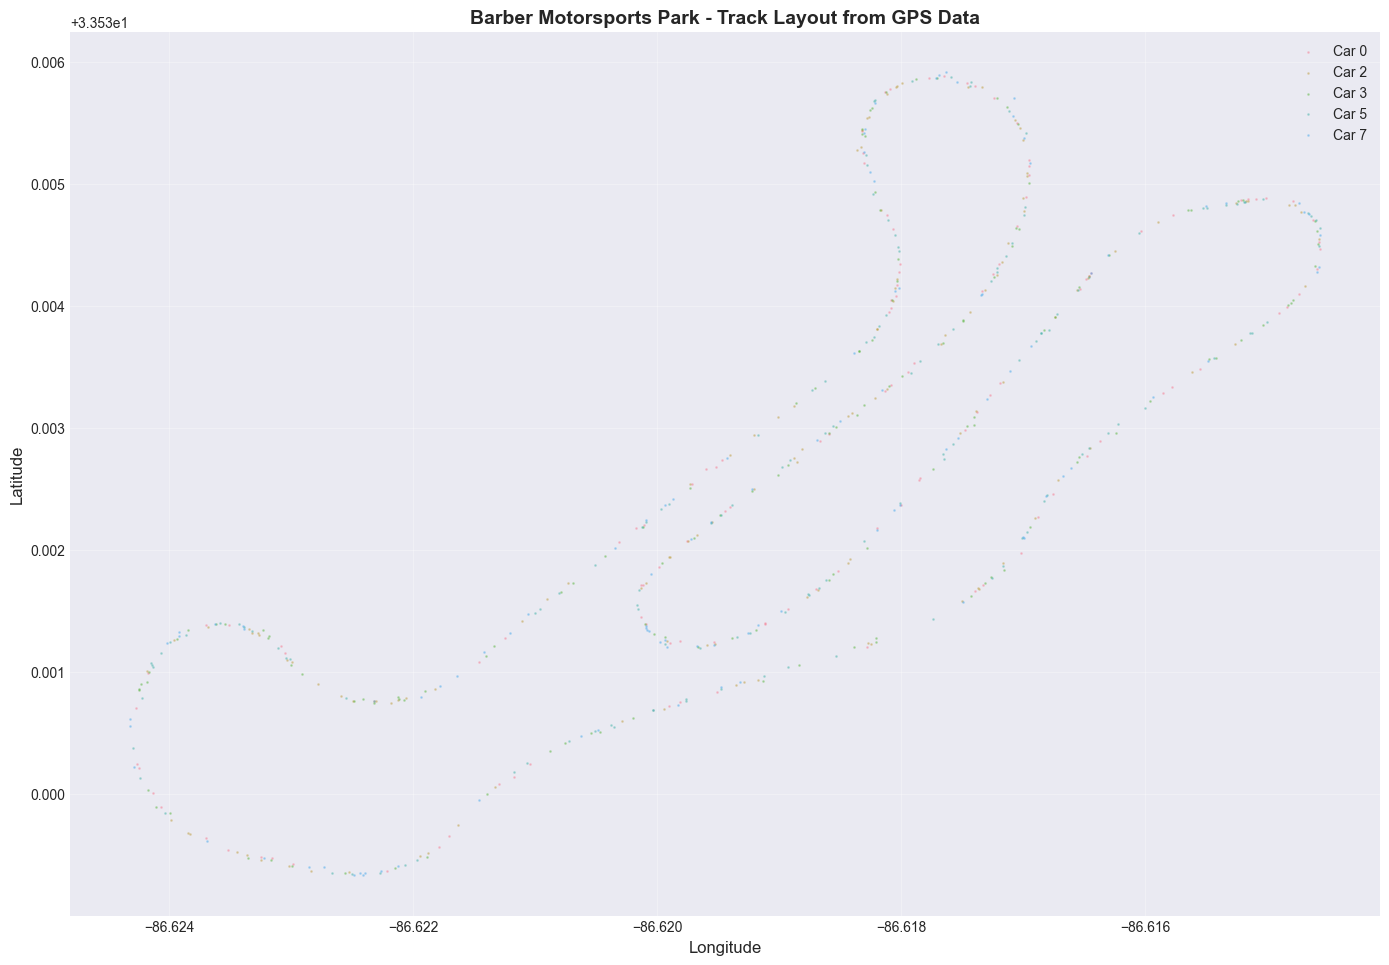

Track coordinates:
  Longitude range: -86.624367 to -86.614487
  Latitude range: 33.529297 to 33.535931


In [9]:
# Plot track layout
fig, ax = plt.subplots(figsize=(14, 10))

# Sample data for performance (every 100th point)
track_sample = pos_df[::100]

# Plot track outline using all cars' GPS data
for car in unique_cars[:5]:  # Plot first 5 cars for clarity
    car_data = track_sample[track_sample['vehicle_number'] == car]
    ax.scatter(car_data['longitude'], car_data['latitude'], 
              s=1, alpha=0.3, label=f'Car {car}')

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Barber Motorsports Park - Track Layout from GPS Data', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("Track coordinates:")
print(f"  Longitude range: {pos_df['longitude'].min():.6f} to {pos_df['longitude'].max():.6f}")
print(f"  Latitude range: {pos_df['latitude'].min():.6f} to {pos_df['latitude'].max():.6f}")

## 5. Race Replay - Position Changes Over Time

Visualize how positions change throughout the race

In [10]:
# Create position chart over time (sample every 10 seconds for readability)
print("Creating position timeline...\n")

# Sample data at regular intervals (every 10 seconds)
pos_df['seconds_from_start'] = (pos_df['timestamp'] - pos_df['timestamp'].min()).dt.total_seconds()

# Sample every 10 seconds
time_intervals = np.arange(0, pos_df['seconds_from_start'].max(), 10)
sampled_positions = []

for t in time_intervals:
    # Get closest timestamp
    closest = pos_df.iloc[(pos_df['seconds_from_start'] - t).abs().argsort()[:len(unique_cars)]]
    closest = closest.drop_duplicates('vehicle_number')
    sampled_positions.append(closest)

position_timeline = pd.concat(sampled_positions, ignore_index=True)

print(f"Position timeline created: {len(position_timeline)} data points")
print(f"Time range: {position_timeline['seconds_from_start'].min():.0f}s to {position_timeline['seconds_from_start'].max():.0f}s")

Creating position timeline...

Position timeline created: 12299 data points
Time range: 0s to 92560s


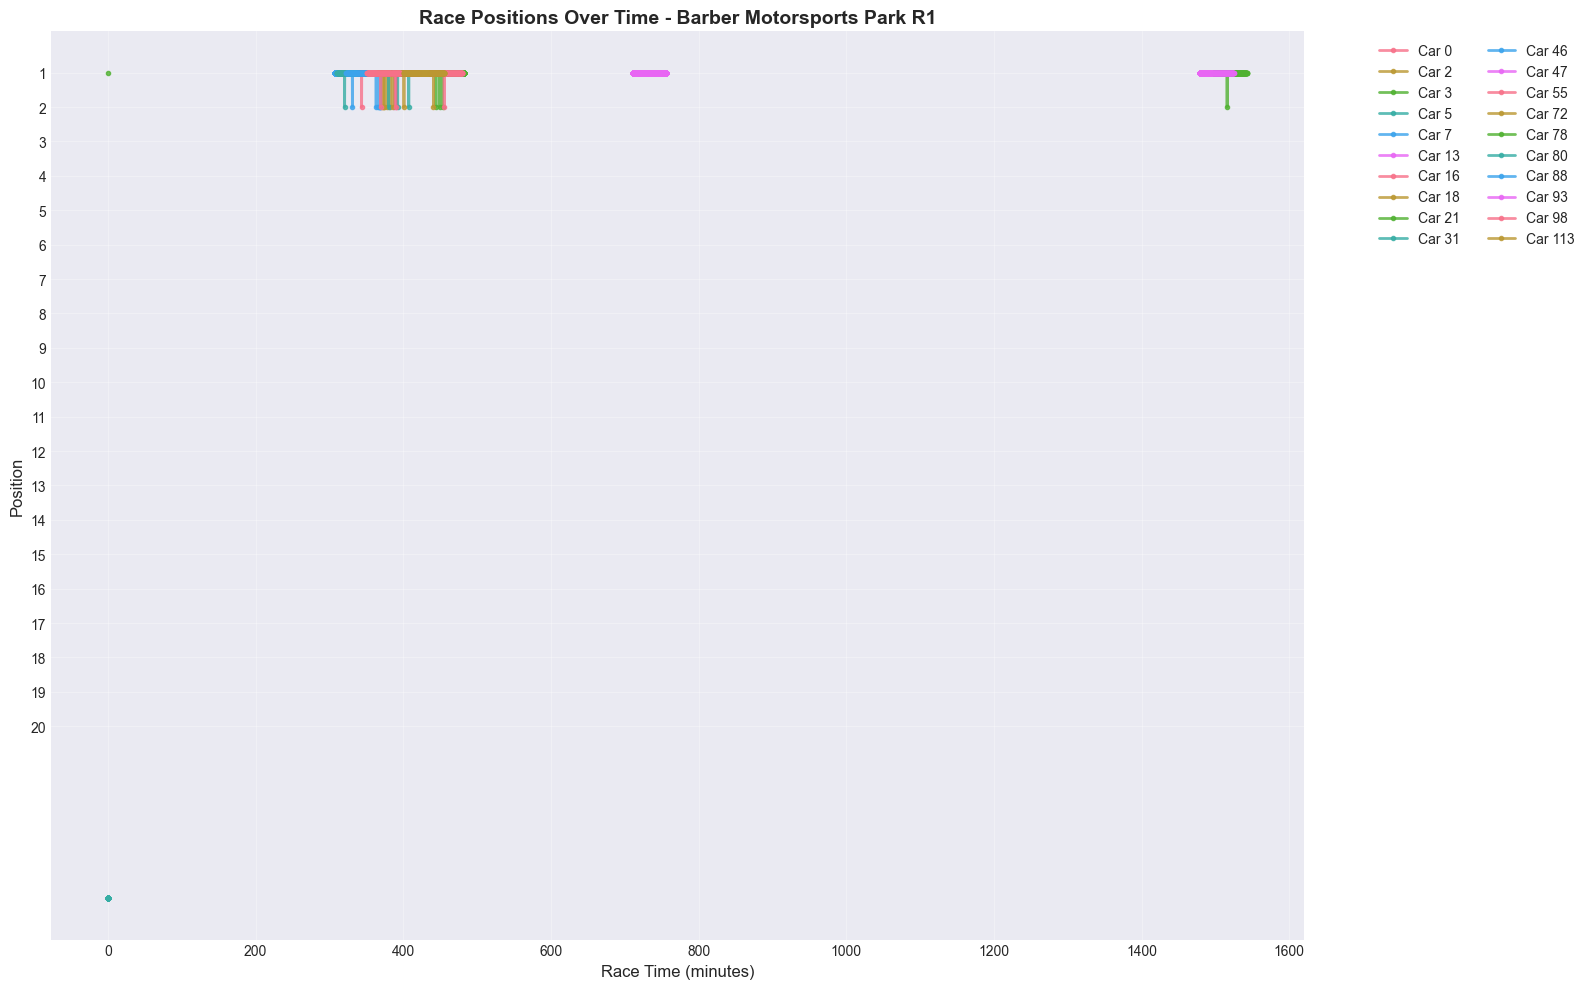

In [11]:
# Plot position changes over time
fig, ax = plt.subplots(figsize=(16, 10))

# Plot each car's position over time
for car in unique_cars:
    car_positions = position_timeline[position_timeline['vehicle_number'] == car].sort_values('seconds_from_start')
    if len(car_positions) > 0:
        ax.plot(car_positions['seconds_from_start'] / 60, 
               car_positions['position'], 
               marker='o', markersize=3, linewidth=2, label=f'Car {car}', alpha=0.8)

ax.set_xlabel('Race Time (minutes)', fontsize=12)
ax.set_ylabel('Position', fontsize=12)
ax.set_title('Race Positions Over Time - Barber Motorsports Park R1', fontsize=14, fontweight='bold')
ax.invert_yaxis()  # Position 1 at top
ax.set_yticks(range(1, len(unique_cars) + 1))
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

## 6. Race Standings Display Function

Create a function to display race standings at any point in time

In [12]:
def display_race_standings(df, time_seconds):
    """Display race standings at a specific time."""
    # Find closest timestamp
    closest_time = df.iloc[(df['seconds_from_start'] - time_seconds).abs().argsort()[:len(unique_cars)]]
    
    # Get unique vehicles and sort by position
    standings = closest_time.drop_duplicates('vehicle_number').sort_values('position')
    
    # Format output
    actual_time = standings['seconds_from_start'].iloc[0]
    minutes = int(actual_time // 60)
    seconds = int(actual_time % 60)
    
    print(f"\n{'='*70}")
    print(f"RACE STANDINGS - {minutes:02d}:{seconds:02d}")
    print(f"{'='*70}")
    print(f"{'Pos':<4} {'Car':<6} {'Lap':<5} {'Distance':<10} {'Interval':<12}")
    print(f"{'-'*70}")
    
    for _, row in standings.iterrows():
        pos = int(row['position'])
        car = int(row['vehicle_number'])
        lap = int(row['lap'])
        dist = int(row['lap_distance'])
        
        if pos == 1:
            interval = "Leader"
        else:
            # Calculate distance gap to leader
            leader_dist = standings.iloc[0]['lap_distance']
            leader_lap = standings.iloc[0]['lap']
            
            if lap < leader_lap:
                interval = f"+{leader_lap - lap} lap(s)"
            else:
                gap = leader_dist - dist
                interval = f"+{gap:.0f}m"
        
        print(f"{pos:<4} {car:<6} {lap:<5} {dist:<10} {interval:<12}")
    
    print(f"{'='*70}\n")

# Test the function at different race times
print("\n=== Race Standings at Different Times ===")

# Start
display_race_standings(position_timeline, 60)  # 1 minute

# Mid-race
mid_time = position_timeline['seconds_from_start'].max() / 2
display_race_standings(position_timeline, mid_time)

# End
display_race_standings(position_timeline, position_timeline['seconds_from_start'].max() - 60)  # 1 min before end


=== Race Standings at Different Times ===

RACE STANDINGS - 00:14
Pos  Car    Lap   Distance   Interval    
----------------------------------------------------------------------
25   80     26    3682       +0m         


RACE STANDINGS - 755:40
Pos  Car    Lap   Distance   Interval    
----------------------------------------------------------------------
1    93     27    3348       Leader      


RACE STANDINGS - 1541:39
Pos  Car    Lap   Distance   Interval    
----------------------------------------------------------------------
1    21     28    1317       Leader      



## 7. Lap-by-Lap Position Changes

Show position changes at the end of each lap

Analyzing lap-by-lap positions...

Position at end of each lap:
vehicle_number  0    2    3    5    7    13   16   18   21   31   46   47   \
lap                                                                          
1               NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  1.0  1.0  NaN   
2               1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3               1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4               1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
5               1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
6               1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
7               1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
8               1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
9               1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
10              1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   


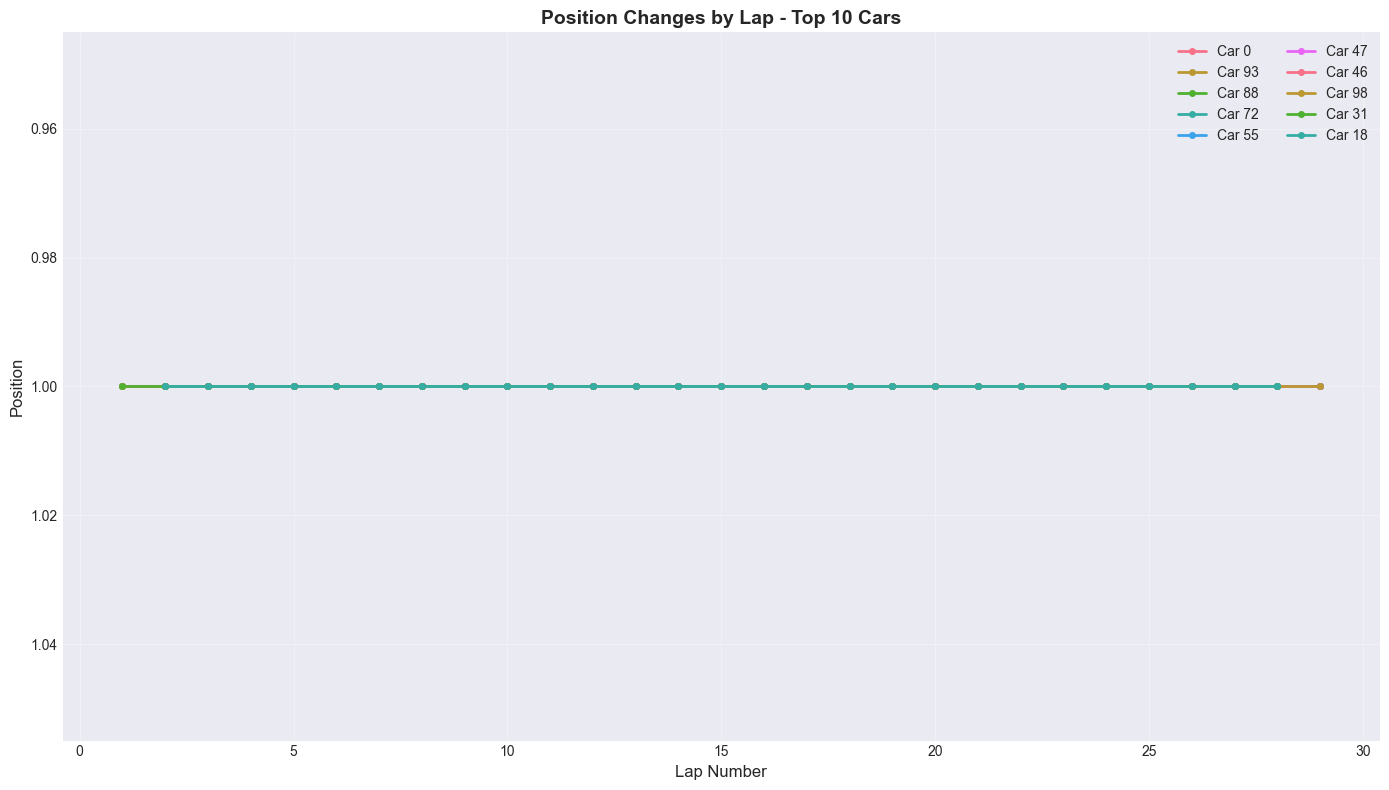

In [13]:
# Get position at end of each lap for each car
print("Analyzing lap-by-lap positions...\n")

# For each car and lap, get max distance (end of lap)
lap_positions = pos_df.sort_values(['vehicle_number', 'lap', 'lap_distance']).groupby(
    ['vehicle_number', 'lap']
).last().reset_index()

# Pivot to show car positions by lap
lap_pivot = lap_positions.pivot(index='lap', columns='vehicle_number', values='position')

print("Position at end of each lap:")
print(lap_pivot.head(15))

# Visualize
fig, ax = plt.subplots(figsize=(14, 8))

# Show top 10 cars
top_cars = lap_positions.groupby('vehicle_number')['position'].mean().sort_values().head(10).index

for car in top_cars:
    car_laps = lap_positions[lap_positions['vehicle_number'] == car]
    ax.plot(car_laps['lap'], car_laps['position'], 
           marker='o', markersize=4, linewidth=2, label=f'Car {car}')

ax.set_xlabel('Lap Number', fontsize=12)
ax.set_ylabel('Position', fontsize=12)
ax.set_title('Position Changes by Lap - Top 10 Cars', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)
ax.legend(loc='best', ncol=2)

plt.tight_layout()
plt.show()

## 8. Summary Statistics

In [14]:
print("\n=== RACE SUMMARY ===")
print(f"\nTotal cars: {len(unique_cars)}")
print(f"Total laps completed: {pos_df.groupby('vehicle_number')['lap'].max().max()}")
print(f"Race duration: {(pos_df['timestamp'].max() - pos_df['timestamp'].min()).total_seconds() / 60:.1f} minutes")

# Final standings
print("\n=== FINAL STANDINGS ===")
final_standings = pos_df[pos_df['timestamp'] == pos_df['timestamp'].max()].sort_values('position')
print(final_standings[['position', 'vehicle_number', 'lap', 'lap_distance']].to_string(index=False))

# Position change statistics
print("\n=== POSITION CHANGES ===")
position_changes = pos_df.groupby('vehicle_number').agg({
    'position': ['min', 'max', 'mean', 'std']
}).round(2)
position_changes.columns = ['Best', 'Worst', 'Average', 'Std Dev']
position_changes = position_changes.sort_values('Average')
print(position_changes)


=== RACE SUMMARY ===

Total cars: 20
Total laps completed: 29
Race duration: 1542.8 minutes

=== FINAL STANDINGS ===
 position  vehicle_number  lap  lap_distance
        1              21   29         270.0

=== POSITION CHANGES ===
                Best  Worst  Average  Std Dev
vehicle_number                               
113                1      2     1.00     0.07
93                 1      1     1.00     0.00
3                  1      2     1.00     0.06
7                  1      2     1.00     0.06
16                 1      2     1.00     0.06
18                 1      2     1.00     0.06
21                 1      2     1.00     0.04
47                 1      2     1.00     0.03
88                 1      3     1.01     0.09
72                 1      2     1.01     0.10
55                 1      2     1.01     0.07
0                  1      2     1.01     0.11
98                 1      2     1.01     0.09
13                 1      3     1.01     0.09
5                  1      3   

## 9. Save Processed Data

Optionally save the processed position data for future use

In [ ]:
# Uncomment to save processed data
# output_file = Path('../outputs/barber_r1_race_positions.parquet')
# output_file.parent.mkdir(parents=True, exist_ok=True)
# pos_df.to_parquet(output_file, index=False)
# print(f"✓ Saved processed data to: {output_file}")

print("\n✓ Analysis complete!")
print("\nNext steps:")
print("  - Analyze speed profiles through corners")
print("  - Compare braking points between drivers")
print("  - Create animated race replay")
print("  - Analyze overtaking zones")